# Project 3: Getting Started 

This notebook is intended to help you get off to a flying start with the cars dataset. You don't have to use this notebook and you can discard any parts you do not like, they are purely intended as a help to get started. 

In [90]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

# optimization
from scipy import optimize
import estimation as est
import estimation_boot as est_boot
import clogit_post as clogit
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in data

The dataset, `cars.csv`, contains cleaned and processed data. If you want to make changes, the notebook, `materialize.ipynb`, creates the data from the raw source datsets. 

In [91]:
cars = pd.read_csv('cars.csv')
lbl_vars = pd.read_csv('labels_variables.csv')
lbl_vals = pd.read_csv('labels_values.csv')

# convert from dataframe to dict
lbl_vals = {c: lbl_vals[c].dropna().to_dict() for c in lbl_vals.columns}

In [92]:
lbl_vars.set_index('variable', inplace=True)

## Overview of the dataset

In [93]:
lbl_vars.join(cars.mean(numeric_only=True).apply(lambda x: f'{x: .2f}').to_frame('Mean'))

,label,Mean
variable,,
ye,year (=first dimension of panel),84.50
ma,market (=second dimension of panel),3.00
co,model code (=third dimension of panel),207.50
zcode,alternative model code (predecessors and succe...,177.76
brd,brand code,16.79
type,name of brand and model,NaN
brand,name of brand,NaN
model,name of model,NaN
org,"origin code (demand side, country with which c...",2.72


# Set up for analysis

In [94]:
price_var = 'princ'

In [95]:
cars['logp'] = np.log(cars[price_var]) # Problem set hint

In [96]:
cars['logp'] = (cars[price_var])/np.log((cars['ngdp']/cars['pop'])) # Brownstone and Train

In [97]:
cars['logp'] = (cars[price_var])  # Brenkers and Verboven


In [98]:
np.mean(cars['logp'])

0.7557170818646749

In [99]:
# new variable: price elasticity heterogeneous for home-region 
cars['logp_x_home'] = cars[price_var] * cars['home']

### Dummy variables

For working with matrices, we want to have a column for each dummy variable. 

In [100]:
categorical_var = 'brand' # name of categorical variable
dummies = pd.get_dummies(cars[categorical_var]) # creates a matrix of dummies for each value of dummyvar

x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])
print(len(x_vars_dummies))
# add dummies to the dataframe 
assert dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars,dummies], axis=1)

32


### `x_vars`: List of regressors to be used 

In [101]:
x_vars = ['logp', 'home', 'cy', 'hp', 'we', 'li'] + x_vars_dummies # <--- !!! choose your preferred variables here 
print(f'K = {len(x_vars)} variables selected.')

K = 38 variables selected.


In [102]:
print(x_vars_dummies)

['MCC', 'VW', 'alfa romeo', 'audi', 'citroen', 'daewoo', 'daf', 'fiat', 'ford', 'honda', 'hyundai', 'innocenti', 'lancia', 'mazda', 'mercedes', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'renault', 'rover', 'saab', 'seat', 'skoda', 'suzuki', 'tal/hillman', 'tal/matra', 'tal/simca', 'tal/sunb', 'talbot', 'toyota', 'volvo']


In [103]:
K = len(x_vars)
N = cars.ma.nunique() * cars.ye.nunique()
J = 40 
x = cars[x_vars].values.reshape((N,J,K))
y = np.log(cars['s'].values.reshape((N,J)))

# standardize x
# x = ((x - x.mean(0).mean(0))/(x.std(0).std(0)))
print(x.shape)

(150, 40, 38)


### Understanding the sorting 

Just to be sure that we understand the relation between the pandas dataframe and the numpy 3d array, consider the following: 

In [104]:
# let's check that we get the same row from x as we can find in the original pandas dataframe
# we'll pick the first 5 "observations"
j = 1
k = 0 
x[:5, j, k] == cars.groupby(['ma','ye']).nth(j)[x_vars[k]].head(5).values

array([ True,  True,  True,  True,  True])

In [105]:
# ... and let's check it for the 5 first cars (in the first market)
k = 0
x[0, :5, k] == cars[x_vars[k]].head(5).values
# note that with i = 3 (4th element), x[i,t,k] gives ma=1 and ye=73 (first market, fourth year)
x[3, :5, k] == cars.query('(ma == 1) & (ye == 73)')[x_vars[k]].head(5).values

array([ True,  True,  True,  True,  True])

In [106]:
# and let's print out some rows along with some labels 
obs_labs = cars[['ma', 'ye', 'type', 's']].values.reshape(N,J,4) # notice that we are extracting the values from the dataframe in the same way as we did for x

i=3 # obs. index 3 is the first market in the fourth (3+1) year, i.e. 73
print(obs_labs[i,:5,:])

i = 130 # obs. index 130 is the 5th country (130/30>4) and the 11th year (130%30 = index 10)
print(obs_labs[i,:5,:])

[[1 73 'audi 80/90' 0.0198967806548532]
 [1 73 'audi 100/200' 0.0115738123314003]
 [1 73 'citroen 2 CV 6 - 2 CV 4' 0.020470221461224]
 [1 73 'citroen GSA/GSX' 0.0231960844492545]
 [1 73 'citroen dyane' 0.0232687741289353]]
[[5 80 'alfasud' 0.0061322294468038]
 [5 80 'citroen GSA' 0.0097859984028077]
 [5 80 'fiat 127' 0.0082314207084408]
 [5 80 'fiat 131F' 0.0099803206146036]
 [5 80 'ford fiesta' 0.0781217905939526]]


... and just checking that we can find those same columns in the pandas dataframe

In [107]:
cars.query('(ma == 5) & (ye == 80) & (type == "ford fiesta")').s

5204    0.078122
Name: s, dtype: float64

# OLS Example

Let's compute the OLS estimator just to test that we can do algebra with the arrays. 

***Note:*** This particular choice of $y$ and $x$ variables might not make sense, it is just to help you get started doing algebra on these arrays. 

In [108]:
Y = y.reshape(N*J,) # Make Y 1-dimensional 
X = np.hstack([x.reshape(N*J,K), np.ones((N*J,1))]).astype(np.float64) # append a constant term and ensure type = float

In [109]:
X.mean(axis=0)

array([7.55717082e-01, 3.16333333e-01, 1.33709042e+03, 5.01000167e+01,
       9.34488833e+02, 7.87377500e+00, 3.33333333e-04, 7.51666667e-02,
       2.26666667e-02, 3.75000000e-02, 7.65000000e-02, 1.00000000e-03,
       4.50000000e-03, 9.46666667e-02, 8.71666667e-02, 1.61666667e-02,
       1.33333333e-03, 2.50000000e-03, 2.08333333e-02, 1.96666667e-02,
       3.55000000e-02, 8.00000000e-03, 4.13333333e-02, 8.28333333e-02,
       7.33333333e-02, 1.09333333e-01, 4.46666667e-02, 1.16666667e-03,
       1.48333333e-02, 3.66666667e-03, 1.16666667e-03, 1.66666667e-03,
       3.33333333e-04, 1.16666667e-02, 1.66666667e-04, 2.08333333e-02,
       2.81666667e-02, 2.01666667e-02, 1.00000000e+00])

In [110]:
# compute the OLS estimator 
bet = np.linalg.inv(X.T @ X) @ X.T @ Y

# print
varnames = x_vars + ['const'] # we added the constant as the K+1'th column 
pd.DataFrame({'Estimate':bet}, index=varnames)

,Estimate
logp,-0.583040
home,0.965552
cy,-0.000295
hp,-0.008302
we,0.001100
li,-0.050792
MCC,-1.169253
VW,0.118337
alfa romeo,-0.487959
audi,-0.086136


# Towards logit 

In order to work with the logit model, you have to be able to compute the utility indices, which typically take the form of some inner product of an $x$-vector and a $\theta$ vector. This is illustrated for you below. Since `x` is `(N,J,K)` (i.e. `x[i,j,:]` gives the $K$-vector of regressors for the car `j` in market-period `i`), we just have to form the matrix product `x @ theta`, and Python will do the sum over the 3rd dimension of `x`. 

In [111]:
theta0 = np.zeros((K,))
v = (x @ theta0).astype(np.float64) # how to multiply a trial value with the matrix of regressors 
np.exp(v) / np.sum(np.exp(v), 1, keepdims=True) # choice probabilities 

array([[0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       ...,
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025]])

# Conditional logit estimation



In [112]:
y = cars['s'].values.reshape((N,J))


In [113]:
res = est.estimate(clogit.q, theta0,  y, x, cov_type = "Sandwich")
#print(res['log_like'])
tab = pd.DataFrame({v:res[v] for v in ['theta', 'se', 't']}, index= x_vars)
tab


Optimization terminated successfully.
         Current function value: 3.467851
         Iterations: 294
         Function evaluations: 11826
         Gradient evaluations: 303


,theta,se,t
logp,-1.316019,0.111716,-11.780049
home,1.352730,0.032297,41.884336
cy,-0.000062,0.000083,-0.747745
hp,-0.005978,0.001904,-3.139491
we,0.000949,0.000171,5.554992
li,-0.036356,0.017415,-2.087658
MCC,-1.303044,0.078160,-16.671511
VW,0.129763,0.056094,2.313300
alfa romeo,-0.778371,0.079260,-9.820512
audi,-0.097469,0.051916,-1.877425


In [114]:
print(res['log_like'])

-553.3319181170893


# Price Elasticities

In [115]:
thetahat = res['theta']
# Calculate the original choice probabilities using the estimated parameters
ccp1 = clogit.choice_prob(thetahat, x)

E_own   = np.zeros((N, J))
E_cross = np.zeros((N, J))
# Due to log price variable being the first element of x_vars, we can use k_price = 0
k_price = 0 

for j in range(J):
    # A. copy 
    x2 = x.copy()
    
    # B. increase price just for car j 
    rel_change_x = 1e-3
    x2[:, j, k_price] *= (1.0+rel_change_x)
    
    # C. evaluate CCPs.  calculate the new choice probabilities with the increased price.
    ccp2 = clogit.choice_prob(thetahat, x2)
    
    # D. percentage change in CCPs 
    rel_change_y = ccp2 / ccp1 - 1.0 
    
    # E. elasticities 
    elasticity = rel_change_y / rel_change_x 
    
    E_own[:, j] = elasticity[:, j]
    k_not_j = [k for k in range(J) if k != j]
    E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1)

print(f'Own-price elasticity:  {np.mean(E_own).round(4)}')
print(f'Cross-price elasticity: {np.mean(E_cross).round(4)}')
print(E_cross)

Own-price elasticity:  -0.9711
Cross-price elasticity: 0.0229
[[0.02555469 0.0154589  0.01625133 ... 0.04072731 0.02536754 0.03141244]
 [0.01428136 0.01621929 0.01517801 ... 0.03043975 0.02625911 0.02998991]
 [0.02508939 0.01427417 0.01644651 ... 0.03927571 0.03122568 0.02767812]
 ...
 [0.01644951 0.01014146 0.00995247 ... 0.01534581 0.05975655 0.01341746]
 [0.01669986 0.01058631 0.00940522 ... 0.00788984 0.06088632 0.01422846]
 [0.01432327 0.00942563 0.01047039 ... 0.01251002 0.01222072 0.01037183]]


In [116]:
def marg_effect_continuous(thetahat, k, x):
    
    # 1. compute derivative: return flattened (N*J, )
    ccp1 = clogit.choice_prob(thetahat, x) 

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    # Due to log price variable being the first element of x_vars, we can use k_price = 0
     

    for j in range(J):
    # A. copy 
        x2 = x.copy()
    
    # B. increase price just for car j 
        rel_change_x = 1e-3
        x2[:, j, k] *= (1.0+rel_change_x)
    
    # C. evaluate CCPs.  calculate the new choice probabilities with the increased price.
        ccp2 = clogit.choice_prob(thetahat, x2)
    
    # D. percentage change in CCPs 
        rel_change_y = ccp2 / ccp1 - 1.0 
    
    # E. elasticities 
        elasticity = rel_change_y / rel_change_x 
    
        E_own[:, j] = elasticity[:, j]
        k_not_j = [k for k in range(J) if k != j]
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1)

    mean_own = np.mean(E_own)
    mean_cross = np.mean(E_cross)
    return mean_own, mean_cross

In [117]:

own, cross  = marg_effect_continuous(thetahat, 0, x)
print(own)
print(cross)

-0.9710592520761605
0.022915134351576355


In [118]:
def estimate_and_compute_marg_effs(starting_values, y, x, k, disp=False): 
    '''Estimate and compute marginal effects
    Args. 
        y: N-vector of discrete outcomes
        x: N*J matrix of explanatory variables
        x0: K-vector of explanatory variables 
        x1: K-vector, alcohol switched on 
        
    Returns
        tuple of floats: 
            me_alco: marginal effect wrt. alcohol (discrete)
            me_educ: marginal effect wrt. education (continuous)
    '''
    # assert y.ndim == 1 , 'y must be a flattened array'
    # assert x.ndim == 2 , 'x must be 2-dimensional'
    
    # 1. estimate 
    res = est_boot.estimate(clogit.q, starting_values, y, x, cov_type="None", options={'disp':disp})
    betahat = res['theta']

    # 3.b marg. effect
    own, cross = marg_effect_continuous(betahat, k, x)
    
    # 4. return 
    return own, cross

In [119]:
estimate_and_compute_marg_effs(theta0, y, x, k = 0)

(-0.9710592520761605, 0.022915134351576355)

In [120]:
def bootstrap_sample(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N, J, K = x.shape

    y_i   = np.zeros((N, J))
    x_i = np.zeros((N, J, K))
    

    ii_boot_n = np.random.choice(N, N, replace=True) # vector of indices for rows 
    ii_boot_j = np.random.choice(J, J, replace=True) # vector of indices for rows 

    for j in range(J):
        for i in range(N):
            y_i[i, j] = y[ii_boot_n[i], ii_boot_j[j]]
            x_i[i, j] = x[ii_boot_n[i], ii_boot_j[j], :] 
    
    return y_i, x_i 

In [121]:
def bootstrap_sample_wrong1(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N, J, K = x.shape

    y_i   = np.zeros((N, J))
    x_i =   np.zeros((N, J, K))
    

   # ii_boot_n = np.random.choice(N, N, replace=True) # vector of indices for rows 
    #ii_boot_j = np.random.choice(J, J, replace=True) # vector of indices for rows 

    for j in range(J):
        for i in range(N):
            ii_boot_n = np.random.choice(N, 1, replace=True) # vector of indices for rows 
            ii_boot_j = np.random.choice(J, 1, replace=True) # vector of indices for rows 
            y_i[i, j] = y[ii_boot_n, ii_boot_j]
            x_i[i, j] = x[ii_boot_n, ii_boot_j, :] 
    
    return y_i, x_i 

In [122]:
def bootstrap_sample_wrong2(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N, J, K = x.shape

    y_i   = np.zeros((N, J))
    x_i =   np.zeros((N, J, K))
    

   # ii_boot_n = np.random.choice(N, N, replace=True) # vector of indices for rows 
    #ii_boot_j = np.random.choice(J, J, replace=True) # vector of indices for rows 

    for j in range(J):
        for i in range(N):
            ii_boot_n = np.random.choice(N, 1, replace=True) # vector of indices for rows 
           
            y_i[i, j] = y[ii_boot_n, j]
            x_i[i, j] = x[ii_boot_n, j] 
    
    return y_i, x_i 

In [123]:
#N = y.shape[0]
#J = y.shape[1]
#K = 38
#y_i   = np.zeros((N, J))
#x_i = np.zeros((N, J, K))
    

#ii_boot_n = np.random.choice(N, N, replace=True) # vector of indices for rows 
#ii_boot_j = np.random.choice(J, J, replace=True) # vector of indices for rows 

#for j in range(J):
 #   for i in range(N):
  #      y_i[i, j] = y[ii_boot_n[i], ii_boot_j[j]]
   #     x_i[i, j] = x[ii_boot_n[i], ii_boot_j[j], :] 
N, J, K = x.shape

y_i   = np.zeros((N, J))
x_i = np.zeros((N, J, K))
    

ii_boot_n = np.random.choice(N, N, replace=True) # vector of indices for rows 
ii_boot_j = np.random.choice(J, J, replace=False) # vector of indices for rows 
print(y[ii_boot_n[i], ii_boot_j[j]])
x[ii_boot_n[i], ii_boot_j[j], :]

0.015837372712584


array([5.17298877e-01, 1.00000000e+00, 1.26300000e+03, 4.40000000e+01,
       8.25000000e+02, 8.39999962e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [126]:


y.shape[0]
y_i, x_i = bootstrap_sample(y,x)
est_boot.estimate(clogit.q, theta0, y_i, x_i, cov_type="None")

Optimization terminated successfully.
         Current function value: 3.421540
         Iterations: 245
         Function evaluations: 9798
         Gradient evaluations: 251


{'theta': array([-1.19458350e+00,  1.29960528e+00, -2.88870241e-04, -3.58136511e-03,
         9.11028767e-04, -1.03278808e-02, -1.12119868e+00,  2.68920568e-01,
        -8.13715788e-01, -3.34030698e-02, -3.33622166e-01, -2.47721393e-01,
        -5.12757220e-01, -2.77168458e-01,  1.21418455e-01, -1.34834898e-01,
        -6.56477503e-01, -1.87437551e+00, -8.25589271e-01, -2.83877343e-01,
         8.31555650e-01, -3.60458837e-01, -2.22883199e-01,  1.45420435e-01,
         1.03431715e-01,  9.81377877e-02, -2.45344279e-01, -1.87875195e-01,
        -7.50856784e-01, -4.76101284e-01, -8.09625247e-01, -7.22796829e-01,
        -2.09417717e+00, -6.80398021e-01,  0.00000000e+00, -3.89709762e-01,
         6.98986373e-04,  9.52069233e-02]),
 'success': True,
 'nit': 245,
 'nfev': 9798,
 'fun': 3.4215397231723017,
 'log_like': -541.6129439893481}

In [127]:
nboot = 2  # Number of bootstraps, should ideally be very large 

# Set seed for random sampling.
seed = 42
rng = default_rng()

# initialize 
own_ela = np.empty((nboot))
cross_ela = np.empty((nboot))

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. choose which individuals to draw
    y_i, x_i = bootstrap_sample(y,x)
    #est.estimate(clogit.q, theta0, y_i, x_i, cov_type="None")
    # 2. estimate and compute 
    own, cross = estimate_and_compute_marg_effs(theta0, y_i, x_i, k = 0)
    own_ela[i] = own
    cross_ela[i] = cross

Bootstrap iteration 1/2
Bootstrap iteration 2/2


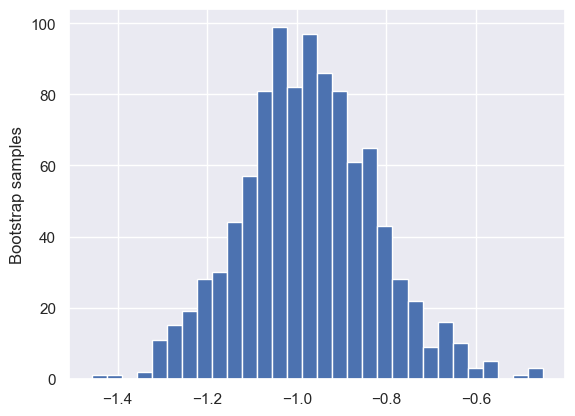

In [ ]:
#j = 1
plt.hist(own_ela, bins=30); 
#plt.xlabel(f'Marginal effect of alcohol on Pr(y={j}) ({y_values_lab[j]})'); 
plt.ylabel('Bootstrap samples'); 

Own price elasticity calculation using calculus

In [ ]:
def me_table(me: np.ndarray): 
    assert me.ndim == 2 
    n_boot,J = me.shape 
    
    m = me.mean(0)
    se = me.std(0)
    tab = pd.DataFrame({
                  'Mean m.e.': m, 
                  '-1.96 se':  m-se*1.96,
                  '+1.96 se':  m+se*1.96
                 })
    return tab 
me_table(own_ela.reshape(-1,1))

,Mean m.e.,-1.96 se,+1.96 se
0,-0.974398,-1.266621,-0.682176


In [128]:
me_table(cross_ela.reshape(-1,1))

,Mean m.e.,-1.96 se,+1.96 se
0,0.023807,0.019708,0.027906


mean -0.974398	+ 1.96 -1.266621  -1.96	-0.682176

In [ ]:
k_price = 0
dydx_J   = np.zeros((N, J))

for j in range(J):

    dydx_J[:,j]= x[:,j,k_price]*(1 - ccp1[:,j]) * thetahat[0]

    # E. elasticities 
print(f'Own price elasticity {np.mean(dydx_J).round(4)}')
# Formula from Green (Econometric Analysis)

Own price elasticity -0.9716


In [ ]:
home = 1
# Create two indexed, from where idx1 is for domestic cars
# and idx0 is for imported cars.
idx1 = x[:, :, home]==1
idx0 = x[:, :, home]==0 
print(f'Elasticity, Domestic cars:   {np.mean(E_own[idx1]).round(4)}')
print(f'Elasticity, Imported cars: {np.mean(E_own[idx0]).round(4)}')

Elasticity, Domestic cars:   -1.0092
Elasticity, Imported cars: -0.9534


In [ ]:
#https://stats.stackexchange.com/questions/283831/delta-method-for-marginal-effects-of-generalized-linear-model

# Numerical partial effect of Home

In [ ]:
k_home = 1
dydx_J   = np.zeros((N, J))

for j in range(J):
    # A. copy 
    x3 = x.copy()
    
    # B. Set car J to home 
    x3[:, j, k_home] = 1
    # C. evaluate CCPs.  calculate the new choice probabilities with the increased price.
    ccp3 = clogit.choice_prob(thetahat, x3)
    
    dydx_J[:,j]= ccp3[:,j] - ccp1[:,j]

    # E. elasticities 
print(f'Average partial effect  {np.mean(dydx_J).round(4)}')

# Ad hoc partial effect
# Effect of "treating" all cars such that they are from "home".
# Note that some cars already are home in some markets.
# This reduce the overall effect in comparison to the next estimate.
home = 1
# Create two indexed, from where idx1 is for domestic cars
# and idx0 is for imported cars.
idx1 = x[:, :, home]==1
idx0 = x[:, :, home]==0 
print(f'Partial effect on untreated (domestic cars):   {np.mean(dydx_J[idx1]).round(4)}')
print(f'Partial effect on treated (Imported cars): {np.mean(dydx_J[idx0]).round(4)}')

Average partial effect  0.0297
Partial effect on untreated (domestic cars):   -0.0
Partial effect on treated (Imported cars): 0.0435


In [ ]:

k_home = 1
PE_J   = np.zeros((N, J))

for j in range(J):
 
    PE_J[:,j]= ccp1[:,j]*(1 - ccp1[:,j]) * thetahat[k_home]

    # E. elasticities 
print(f'Partial effect  {np.mean(PE_J).round(4)}')
# Formula from Greene (Econometric analysis)
# Does not account for cars already being from home

Partial effect  0.0325


# Calculate CI for partial effects using delta method

# CFH attempt

In [ ]:
x_vars

['logp',
 'home',
 'cy',
 'hp',
 'we',
 'li',
 'MCC',
 'VW',
 'alfa romeo',
 'audi',
 'citroen',
 'daewoo',
 'daf',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'innocenti',
 'lancia',
 'mazda',
 'mercedes',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'suzuki',
 'tal/hillman',
 'tal/matra',
 'tal/simca',
 'tal/sunb',
 'talbot',
 'toyota',
 'volvo']

In [ ]:
#create mean variables with shape to match all alernatives
m_logp = np.mean(x[:, :, 0], axis=0)
m_cy = np.mean(x[:, :, 2], axis=0)
m_hp = np.mean(x[:, :, 3], axis=0)
m_we = np.mean(x[:, :, 4], axis=0)
m_li = np.mean(x[:, :, 5], axis=0)

In [ ]:
m_logp.shape

(40,)

In [ ]:
len(x_vars_dummies)

32

In [ ]:
#construct x0
x0 = np.zeros((1, 40, len(x_vars)))
x0[0, :, 0] = m_logp
x0[0, :, 2] = m_cy
x0[0, :, 3] = m_hp
x0[0, :, 4] = m_we
x0[0, :, 5] = m_li

#remember now the brand is bmw since all brand dummies included are set to 0
#think about how to deal with this

In [ ]:
#construct x1
x1 = x.copy()
x1[:, :, 1] = 1
x.shape

(150, 40, 38)

In [ ]:
#calculate choice probabilities
prob_x0 = clogit.choice_prob(thetahat, x0)
prob_x1 = clogit.choice_prob(thetahat, x1)

#calculate the marginal effect
PE_J_new = prob_x1 - prob_x0

In [ ]:
#intermezzo: calculate the average marginal effect
#calculate the average marginal effect
PE_J_new_avg = np.mean(PE_J_new, axis=0)
print(f'Average partial effect  {np.mean(PE_J_new_avg).round(4)}')

Average partial effect  0.0


In [ ]:
#Print shapes
print(prob_x0.shape)
print(x1.shape)

(1, 40)
(150, 40, 38)


In [ ]:
#calculate the gradient
#grad_new = prob_x1.T@(1-prob_x1)@x1 - prob_x0.T@(1-prob_x0)@x0
#grad_new = prob_x1.T@(1-prob_x1)@x1 - prob_x0.T@(1-prob_x0)@x0
grad_new = prob_x1.T@(1-prob_x1)@thetahat
grad_new = grad_new.reshape((J,K))
print(grad_new.shape)
print(grad_new)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 38 is different from 40)

In [ ]:
#read the covariance matrix
cov_new = res['cov']
print(cov_new.shape)

(38, 38)


In [ ]:
def get_se(grad, cov):
    cov_me = grad@cov@grad.T
    return np.sqrt(np.diag(cov_me))

se_choice = get_se(grad_new, cov_new)

In [ ]:
se_choice.shape

(40,)

In [ ]:
se_choice

array([0.07110373, 0.06262595, 0.07465416, 0.08189616, 0.0989034 ,
       0.09826494, 0.10208988, 0.10185784, 0.10402552, 0.09706846,
       0.09278799, 0.09270627, 0.08905862, 0.08622328, 0.08601389,
       0.09384938, 0.0891499 , 0.08391333, 0.09151576, 0.09102549,
       0.08681567, 0.08917283, 0.08975035, 0.0912445 , 0.08883985,
       0.093682  , 0.09924068, 0.10063967, 0.09577442, 0.09375603,
       0.0958558 , 0.0930271 , 0.08981248, 0.09801062, 0.098816  ,
       0.10104478, 0.09788313, 0.0991339 , 0.0913937 , 0.08162909])